# Introduction

+ This is the source code of Shuyang Lin's capstone project, guided by Prof. Peter Haslag.

+ This capstone project aims to examine the applicability of text analytics to describe the pattern of companies in the job demand market. 

+ A large dataset containing 607,795 rows of job descriptions from various companies and years was utilized. The analytics process includes the following steps: data cleaning, vectorizing, dimensionality reduction, clustering, visualization, topic modeling, and similarity score calculation. 

+ The output consists of two datasets: one with cluster labels for each company in a given year, representing the type of job demand, and another with pairwise cosine similarity scores for comparing job demands between companies in the same year or the same company across different years.

# Load packages


## Mount google drive (path change needed)

This notebook is primarily run on Google Colab. The following block is used to mount the path to a google drive. Please change the String variable **path** as needed.

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/capstone_data/"

Mounted at /content/drive


## Dependency installation

Most packages are already installed by Colab. There're possibly a few dependency conflicts, so a manual check of update is set here.

In [2]:
# use pip to upgrade and install needed packages
!pip install -U scikit-learn
!pip install scikit-learn-intelex
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 78.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import packages

In [3]:
# confirm encoding format
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
# Intel CPU-accelerated sklearn
from sklearnex import patch_sklearn
import sklearnex
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
# for plot
import textwrap

In [6]:
import scipy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud  
import string
import re
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import joblib
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer 
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
from kneed import KneeLocator
import itertools
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [7]:
# python multiprocessing
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

In [8]:
# progress bar package
from tqdm import tqdm
tqdm.pandas()

In [9]:
# nltk corpus download
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load raw data

The loaded data is described as:

> The data is ~1.6gb and has the first job description each year for the firm-occupation. It also includes the number of job posts that were created for that firm-occupation-year. It doesn’t have the geographic data at this point because it was going to enlarge the data substantially.

In [ ]:
# firm-occupation-year.csv
# LinkUp_JobDesc_Sample.csv
df_raw = pd.read_csv(path + "firm-occupation-year.csv", sep="|").fillna("Nan values")

The data has text, year, onet_occupation code, number of postings, and gvkey.

[Text(0, 0, '11'),
 Text(1, 0, '13'),
 Text(2, 0, '15'),
 Text(3, 0, '17'),
 Text(4, 0, '19'),
 Text(5, 0, '21'),
 Text(6, 0, '23'),
 Text(7, 0, '25'),
 Text(8, 0, '27'),
 Text(9, 0, '29'),
 Text(10, 0, '31'),
 Text(11, 0, '33'),
 Text(12, 0, '35'),
 Text(13, 0, '37'),
 Text(14, 0, '39'),
 Text(15, 0, '41'),
 Text(16, 0, '43'),
 Text(17, 0, '45'),
 Text(18, 0, '47'),
 Text(19, 0, '49'),
 Text(20, 0, '51'),
 Text(21, 0, '53'),
 Text(22, 0, '55'),
 Text(23, 0, '99')]

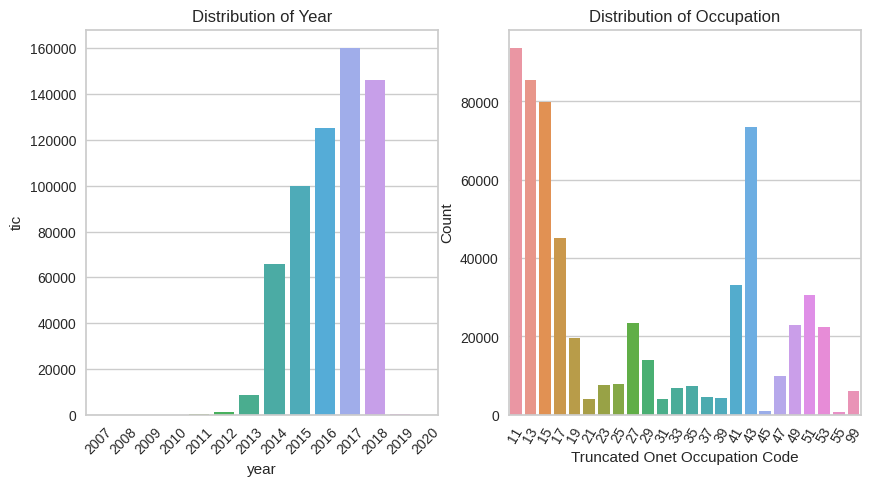

In [ ]:
# plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Distribution of Year')
sns.barplot(df_raw.groupby(['year'])['tic'].count().reset_index() ,x='year', y='tic', ax=ax[0])
ax[0].set_xticklabels(labels = list(range(2007,2021)), rotation=45)
ax[1].set_title('Distribution of Occupation')
df_raw['occupation_industry'] = df_raw.onet_occupation_code.map(lambda x: x[:2])
occu_count = df_raw.groupby(['occupation_industry'])['description'].count().reset_index()
sns.barplot(occu_count, x='occupation_industry', y= 'description', ax=ax[1])
ax[1].set_xlabel('Truncated Onet Occupation Code')
ax[1].set_ylabel('Count')
ax[1].set_xticklabels(labels = occu_count.occupation_industry, rotation=60)

<Axes: title={'center': 'Distribution of Job Description Length'}, xlabel='Length of Job Description', ylabel='Density'>

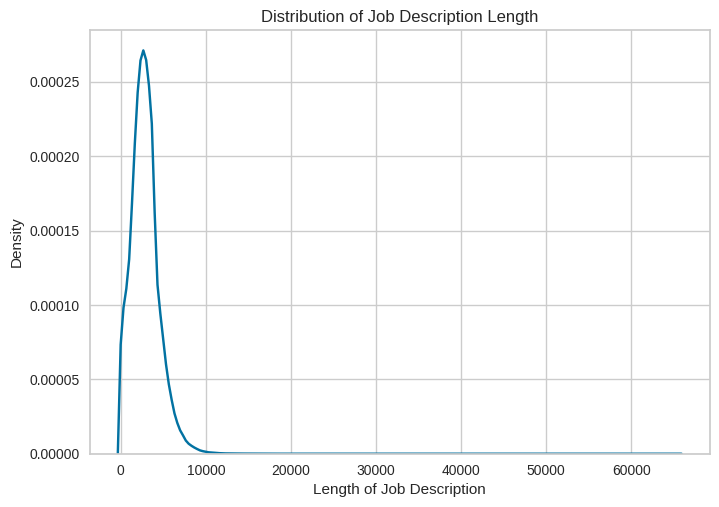

In [ ]:
# plot distribution of raw description lengths
df_raw['len'] = df_raw['description'].map(len)
plt.title('Distribution of Job Description Length')
plt.xlabel('Length of Job Description')
sns.kdeplot(df_raw.len)

# Transform/cleaning


The project used package **nltk** to clean the text. The cleaning includes:

+ Stopwords and additional words removal
+ Hyperlinks removal
+ Star words removal
+ Numbers removal
+ Punctuation removal
+ Extra space removal
+ To lower case

The process is very time-consuming.

In [ ]:
# load stopwords
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load punctuations
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Here's a list of common words frequency generated from the raw test in previous exploration steps. They were then removed during data cleaning.

> [('team', 404755),
 ('customer', 351158),
 ('experience', 336996),
 ('product', 234314),
 ('work', 227640),
 ('ability', 214509),
 ('service', 188427),
 ('skill', 177701),
 ('business', 166077),
 ('member', 159987),
 ('job', 136507),
 ('food', 130076),
 ('nbsp', 124695),
 ('management', 117434),
 ('amazon', 112417),
 ('requirement', 111177),
 ('qualification', 109358),
 ('strong', 108931),
 ('technical', 98556),
 ('development', 98000),
 ('department', 96893),
 ('environment', 91317),
 ('duty', 89658),
 ('software', 89603),
 ('system', 89463),
 ('support', 88152),
 ('year', 87612),
 ('technology', 85934),
 ('role', 85270),
 ('microsoft', 85168)]

In [ ]:
# Extend stop words list
additional_stopwords = ['team', 'customer', 'experience', 'product', 'work', 'ability',
                        'service', 'skill', 'business', 'member', 'job', 'food', 'nbsp',
                        'amazon', 'requirement','qualification','microsoft', 'junior', 'senior',
                        'experience','etc','job','work','company','technique',
                        'candidate','skill','skills','language','menu','inc','new','plus','years',
                        'technology','organization','ceo','cto','account','manager','scientist',
                        'developer','product','revenue','strong', 'req', 'id']

#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

stop_words.extend(additional_stopwords)
stop_words.extend(sw_spacy)

In [ ]:
# Remove URLs
def remove_urls(s):
    s = re.sub('[^\s]*.com[^\s]*', "", s)
    s = re.sub('[^\s]*www.[^\s]*', "", s)
    s = re.sub('[^\s]*.co.uk[^\s]*', "", s)
    return s

# Remove the star_words
def remove_star_words(s):
    return re.sub('[^\s]*[\*]+[^\s]*', "", s)

# Remove numbers
def remove_nums(s):
    return re.sub('[^\s]*[0-9]+[^\s]*', "", s)

# Remove the punctuations
from string import punctuation

def remove_punctuation(s):
    global punctuation
    for p in punctuation:
        s = s.replace(p, '')
    return s


# define a function to remove stopwords from descriptions
def remove_stopwords(s):
    global stop_words
    s = nltk.tokenize.word_tokenize(s)
    s = " ".join([w for w in s if w not in stop_words])
    return s

# define clean text
def clean_text(text):
    text = re.sub('![a-zA-Z0-9]', ' ', text.lower().strip())
    text = re.sub(r'\s+', ' ', text)
    text = ''.join(c for c in text if c not in string.punctuation)
    return text

# specific characters
def clean_text_2(s):
    if s=='<NA>':
        return ""
    ls = ["â",'â','â·','â\x80¢', u"â·",'â']
    for x in ls:
        s.replace(x,"")
    return s
    

# do all cleaning
def clean(s):
    try:
        s = ''.join(i for i in s if ord(i)<128)
        s = s.lower()
        s = remove_star_words(s)
        s = remove_nums(s)
        s = remove_punctuation(s)
        s = remove_stopwords(s)
        s = clean_text(s)
        s = clean_text_2(s)
        return s
    except Exception as e:
        return ""

**The following step takes very long time**

In [ ]:
# takes very long time
ntime = time.time()
df['clean_description'] = df['description'].map(clean)
print(time.time()-ntime)

4.100799560546875e-05


In [ ]:
# save the cleaned data to google drive
df.to_csv(path + "foy_cleaned.csv", sep="|")

In [ ]:
# if RAM limited, uncomment the following code and delete df
# del df

# Process occupation

The occupation code is too long and too complex. To explore the occupations in groups, the code is processed.

In [ ]:
# read the cleaned data
df = pd.read_csv(path + "foy_cleaned.csv", sep = "|", index_col = 0)

In [ ]:
df_raw = df['description']

In [ ]:
# as the cleaned description is saved, no need to keep the raw text
df.drop('description', axis=1, inplace = True)

In [ ]:
len(df.gvkey.unique())

2952

There are 2952 companies in the data.

In [ ]:
len(df.year.unique())

14

Includes 14 years.

In [ ]:
len(df.onet_occupation_code.unique())

1010

With 1010 occupations.

In [ ]:
df['occupation_l'] = df.onet_occupation_code.map(lambda x: x[:2])

In [ ]:
len(df.occupation_l.unique())

24

24 occupation groups with the first 2 digits.

In [ ]:
df['occupation_m'] = df.onet_occupation_code.map(lambda x: x[:4])

In [ ]:
len(df.occupation_m.unique())

99

Text(0, 0.5, 'Count')

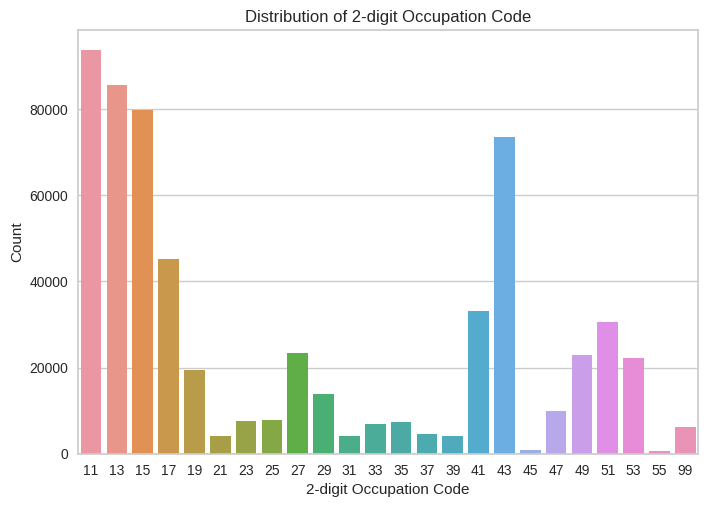

In [ ]:
t = df.groupby(['occupation_l'])['tic'].count().reset_index()
sns.barplot(x=t['occupation_l'], y=t['tic'])
plt.title('Distribution of 2-digit Occupation Code')
plt.xlabel('2-digit Occupation Code')
plt.ylabel('Count')

# Sample selection

As the dataset is a bit large for an exploration, the project decided to select top 500 companies (of the number of job posts) to continue.

In [ ]:
# Select top 500 companies of job demands
jd_count = df.groupby(['gvkey'])['number_of_posts_all'].sum().reset_index().sort_values(by='number_of_posts_all' ,ascending=False)

In [ ]:
len(df['gvkey'].unique())

2952

In [ ]:
jd_count.head(500)

gvkey  number_of_posts_all
1994   65417              1242568
350     6829               591424
164     3813               519302
371     7241               447444
317     6307               374320
...      ...                  ...
1904   63447                 6841
322     6379                 6821
2413  160479                 6796
1304   25313                 6783
2172  124042                 6770

[500 rows x 2 columns]

The number of posts is skewed. To focus only on the scale, **log(n)** is used instead of the raw number **n**.

In [ ]:
df['log_num'] = df['number_of_posts_all'].progress_apply(lambda x: np.round(np.log(x)/np.log(10) + 1))

100%|██████████| 607795/607795 [00:06<00:00, 100210.79it/s]


In [ ]:
df = df[df['gvkey'].isin(jd_count.head(500).gvkey)]

In [ ]:
# df = df.drop(['description'], axis=1)

In [ ]:
df = df.dropna(subset=['clean_description'])

In [ ]:
df = df.reindex(df.index.repeat(df.log_num)).reset_index(drop=True)

In [ ]:
df = df[df.clean_description.map(len)>=200]

<Axes: title={'center': 'Distribution of Cleaned Job Description Length'}, xlabel='Length of Cleaned Job Description', ylabel='Density'>

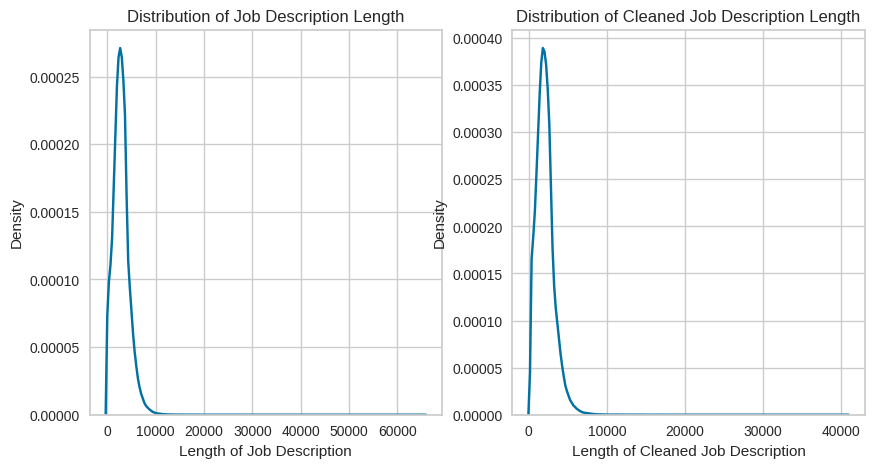

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Distribution of Job Description Length')
ax[0].set_xlabel('Length of Job Description')
sns.kdeplot(df_raw.apply(len), ax=ax[0])
ax[1].set_title('Distribution of Cleaned Job Description Length')
ax[1].set_xlabel('Length of Cleaned Job Description')
sns.kdeplot(df.clean_description.map(len), ax=ax[1])

In [ ]:
df

tic onet_occupation_code  year  number_of_posts_all   gvkey  \
0       AIR           13-1111.00  2014                    2    1004   
1       AIR           13-1141.00  2014                    1    1004   
2       AIR           13-1151.00  2014                    1    1004   
3       AIR           15-1252.00  2014                    2    1004   
4       AIR           17-2011.00  2014                    6    1004   
...     ...                  ...   ...                  ...     ...   
491232  CAB           53-7065.00  2016                  622  264708   
491233  CAB           53-7065.00  2016                  622  264708   
491234  CAB           53-7065.00  2016                  622  264708   
491235  CAB           99-9999.00  2016                   30  264708   
491236  CAB           99-9999.00  2016                   30  264708   

                                        clean_description occupation_l  \
0       position summary leads small teams problem sol...           13   
1       position summary airbus group seeking experien...           13   
2       position summary responsible assisting schedul...           13   
3       position summary responsible developing modify...           15   
4       working worlds leading aircraft manufacturer m...           17   
...                                                   ...          ...   
491232  postingbrassring vacancy rtl inventory merch a...           53   
491233  postingbrassring vacancy rtl inventory merch a...           53   
491234  postingbrassring vacancy rtl inventory merch a...           53   
491235  cabelas retail hiring parttime retail associat...           99   
491236  cabelas retail hiring parttime retail associat...           99   

       occupation_m  log_num  
0              13-1      1.0  
1              13-1      1.0  
2              13-1      1.0  
3              15-1      1.0  
4              17-2      2.0  
...             ...      ...  
491232         53-7      4.0  
491233         53-7      4.0  
491234         53-7      4.0  
491235         99-9      2.0  
491236         99-9      2.0  

[471674 rows x 9 columns]

# Job word cloud

To have a glance of each occupation, word clouds are used.

In [ ]:
df['clean_description'] = df['clean_description'].fillna('Nan').astype(str)

<ipython-input-76-bb1f3ae219c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_description'] = df['clean_description'].fillna('Nan').astype(str)


In [ ]:
# aggregate large occupation
a_occul = df.groupby(['occupation_l'])['clean_description'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
a_occul

occupation_l                                  clean_description
0            11  working worlds leading aircraft manufacturer m...
1            13  position summary leads small teams problem sol...
2            15  position summary responsible developing modify...
3            17  working worlds leading aircraft manufacturer m...
4            19  sense avoid capabilities uavs planetary landin...
5            21  sie sind vollzeitstudent auf der suche nach ei...
6            23  airbus group american operating airbus group w...
7            25  position summary working airbus training centr...
8            27  position summary selected responsible supporti...
9            29  au sein de lentit achats et management supply ...
10           31  sie sind auf der suche nach einem praktikum un...
11           33  vacancy ho security operations france toulouse...
12           35  au sein de la ligne de production equipements ...
13           37  sie sind vollzeitstudent auf der suche nach ei...
14           39  le programme volontariat international vie est...
15           41  secure sales airbus helicopter incs training s...
16           43  satair founded world leading supplier aircraft...
17           45  fr airbus defence space manching suchen wir fr...
18           47  position summary perform assigned aircraft par...
19           49  plan develop manage activities necessary proce...
20           51  position summary training position applicable ...
21           53  position summary plan direct execute helicopte...
22           55  vacancy mrtt air refueling operator instructor...
23           99  airbus group american operating airbus group w...

  0%|          | 0/24 [00:00<?, ?it/s]


*** 11 ***



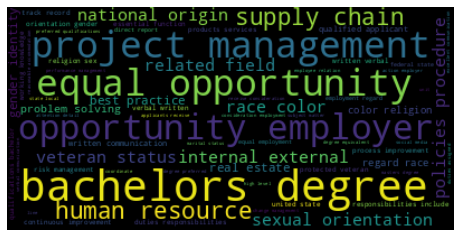

  4%|▍         | 1/24 [01:28<33:45, 88.05s/it]


*** 13 ***



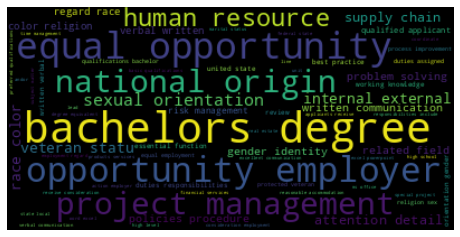

  8%|▊         | 2/24 [02:31<27:01, 73.69s/it]


*** 15 ***



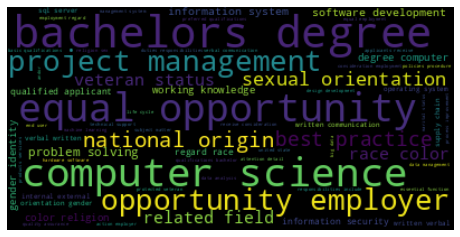

 12%|█▎        | 3/24 [03:34<23:59, 68.54s/it]


*** 17 ***



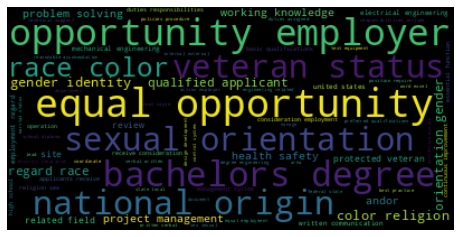

 17%|█▋        | 4/24 [04:07<18:10, 54.51s/it]


*** 19 ***



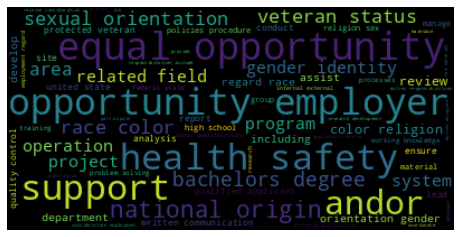

 21%|██        | 5/24 [04:24<12:58, 40.97s/it]


*** 21 ***



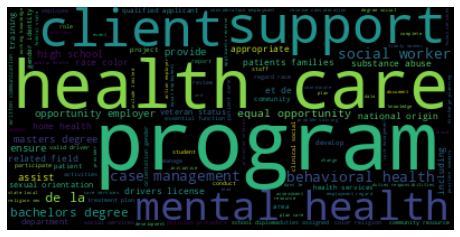

 25%|██▌       | 6/24 [04:32<08:55, 29.76s/it]


*** 23 ***



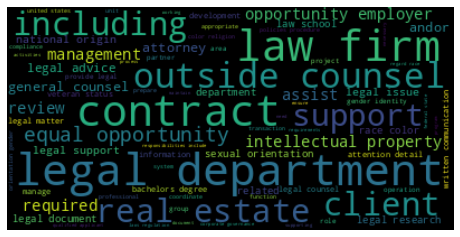

 29%|██▉       | 7/24 [04:38<06:16, 22.17s/it]


*** 25 ***



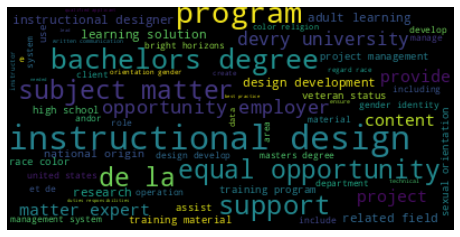

 33%|███▎      | 8/24 [04:46<04:41, 17.60s/it]


*** 27 ***



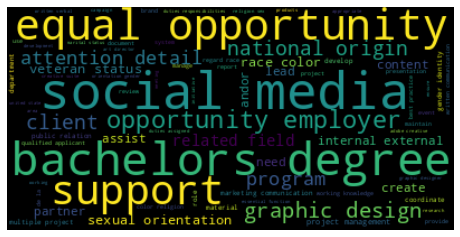

 38%|███▊      | 9/24 [05:07<04:38, 18.59s/it]


*** 29 ***



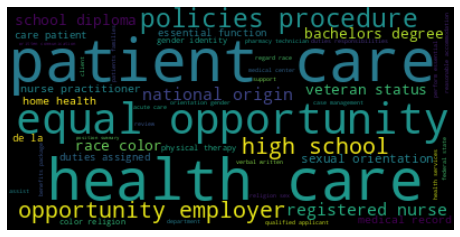

 42%|████▏     | 10/24 [05:23<04:09, 17.81s/it]


*** 31 ***



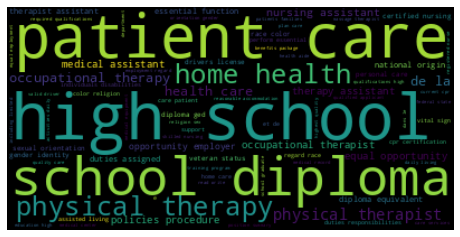

 46%|████▌     | 11/24 [05:28<03:01, 13.96s/it]


*** 33 ***



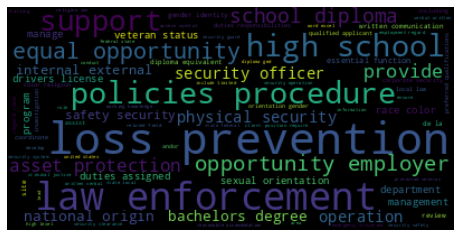

 50%|█████     | 12/24 [05:37<02:28, 12.39s/it]


*** 35 ***



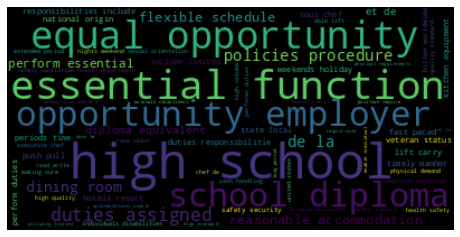

 54%|█████▍    | 13/24 [05:45<02:03, 11.21s/it]


*** 37 ***



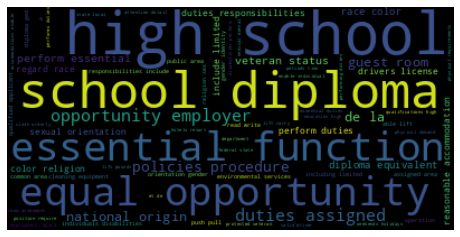

 58%|█████▊    | 14/24 [05:50<01:32,  9.29s/it]


*** 39 ***



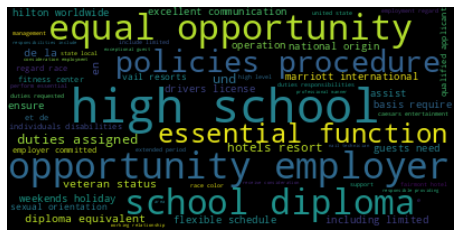

 62%|██████▎   | 15/24 [05:55<01:11,  7.89s/it]


*** 41 ***



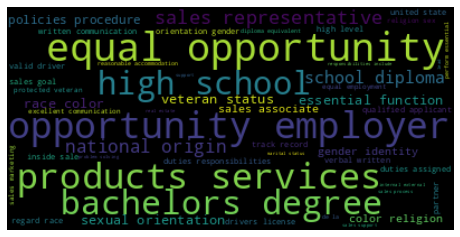

 67%|██████▋   | 16/24 [06:24<01:53, 14.20s/it]


*** 43 ***



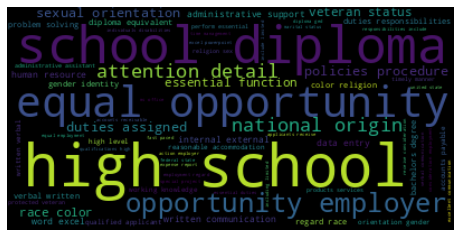

 71%|███████   | 17/24 [07:11<02:48, 24.08s/it]


*** 45 ***



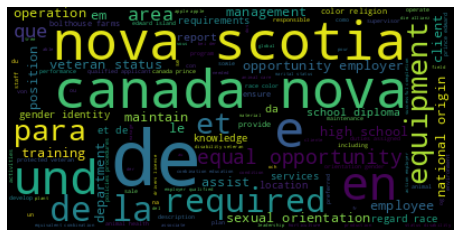

 75%|███████▌  | 18/24 [07:12<01:43, 17.25s/it]


*** 47 ***



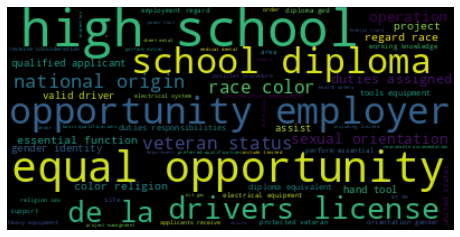

 79%|███████▉  | 19/24 [07:20<01:11, 14.34s/it]


*** 49 ***



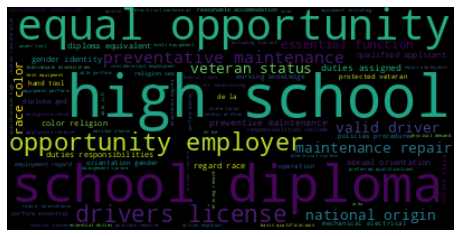

 83%|████████▎ | 20/24 [07:38<01:02, 15.56s/it]


*** 51 ***



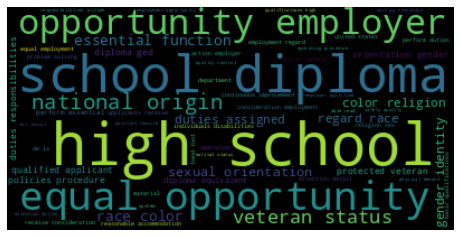

 88%|████████▊ | 21/24 [07:58<00:50, 16.89s/it]


*** 53 ***



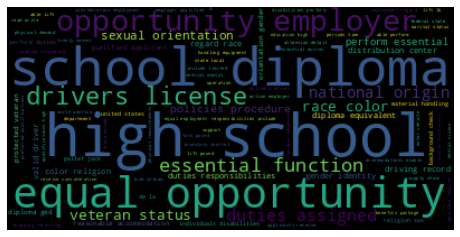

 92%|█████████▏| 22/24 [08:16<00:34, 17.25s/it]


*** 55 ***



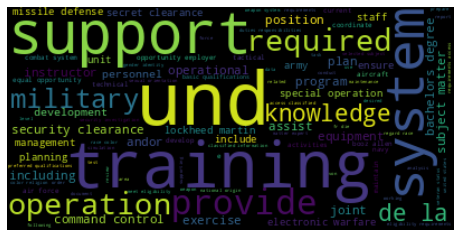

 96%|█████████▌| 23/24 [08:18<00:12, 12.52s/it]


*** 99 ***



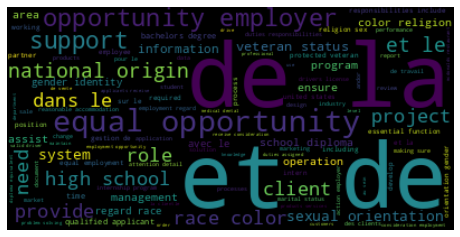

100%|██████████| 24/24 [08:23<00:00, 21.00s/it]


In [ ]:
occul_list = a_occul.occupation_l.unique().tolist()


for job in tqdm(occul_list):

    # Start with one review:
    text = a_occul[a_occul.occupation_l == job].clean_description.iloc[0]
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Clustering

The first step of clustering is to vectorize the cleaned text. TF-IDF is used here.

## TF-IDF Vectorization

Concatenate the text within a company in a year.

In [ ]:
# use agg to concatenate text
firm_year = df.dropna(subset = ['clean_description']).groupby(['gvkey','year'])['clean_description'].agg(lambda x: " ".join(x)).reset_index()

In [ ]:
firm_year

gvkey  year                                  clean_description
0       1004  2014  position summary leads small teams problem sol...
1       1004  2015  working worlds leading aircraft manufacturer m...
2       1004  2016  position summary identify engage interdepartme...
3       1004  2017  airbus global leader aeronautics space related...
4       1004  2018  sie sind vollzeitstudent auf der suche nach ei...
...      ...   ...                                                ...
2945  260774  2019  key roles responsibilities generate execute ac...
2946  264708  2013  position overview primary purpose operations p...
2947  264708  2014  position overview primary purpose operations p...
2948  264708  2015  position overview primary purpose operations p...
2949  264708  2016  cabelas worlds foremost outfitter hunting fish...

[2950 rows x 3 columns]

In [ ]:
# use sklearn tfidf vectorizer
# change max_features to modify the number of columns
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), max_features=2**12)
X = vectorizer.fit_transform(firm_year.clean_description)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# show the shape of the matrix
X

<2950x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 5018755 stored elements in Compressed Sparse Row format>

In [ ]:
# save the matrix to google drive
pd.DataFrame(X.toarray()).to_csv(path + "vectorized_X.csv")

## Dimensionality reduction

As the default output set to be 4096 columns, dimensionality reduction is used to simplify the calculation. Truncated SVD, which is a good method for sparse matrix, is used.

In [53]:
# If run from beginning, comment this
# X = scipy.sparse.csr_matrix(pd.read_csv(path + "vectorized_X.csv", index_col = 0))

In [54]:
# sklearn.decomposition.TruncatedSVD
# change n_components to modify the number of columns
svd = TruncatedSVD(n_components=100, random_state=114514)
X_reduced= svd.fit_transform(X.toarray())
X_reduced.shape

(2950, 100)

In [55]:
# show the sum of explained variance ratio
svd.explained_variance_ratio_.sum()

0.4775115251540125

Around 47.7% described.

In [56]:
# check if singular values larger than 1
svd.singular_values_

array([28.99145986,  8.93984081,  7.57627015,  7.01975391,  6.50424938,
        5.9331917 ,  5.60309787,  5.02034606,  4.89369239,  4.78748033,
        4.05939535,  3.86445849,  3.75578039,  3.66126792,  3.47860964,
        3.3851823 ,  3.23798297,  3.20947689,  3.18342896,  3.09871527,
        3.07640973,  3.03771233,  3.02118966,  2.94380494,  2.91686716,
        2.90355341,  2.85366943,  2.83244849,  2.80175446,  2.76350417,
        2.72912418,  2.70792557,  2.7034469 ,  2.65701706,  2.63588918,
        2.60032212,  2.59892938,  2.57260455,  2.56756729,  2.5449304 ,
        2.52833944,  2.51110222,  2.49326235,  2.47923007,  2.46403759,
        2.44792988,  2.44086402,  2.42828211,  2.4078486 ,  2.4055647 ,
        2.40012301,  2.38263535,  2.3743909 ,  2.37172151,  2.36314809,
        2.35723816,  2.35049771,  2.34210945,  2.33822101,  2.33210485,
        2.31618452,  2.3134803 ,  2.30736448,  2.29822367,  2.29565082,
        2.28124183,  2.27795664,  2.27201179,  2.26621155,  2.25

## DBSCAN Clustering

DBSCAN is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

Two hyper parameters are needed for DBSCAN:

+ Epsilon
+ Min points

### Find best epsilon

Use nearest neighbors and elbow method, a good epsilon could be located.

In [ ]:
# check average distance to nearest neighbors
neighbors = 6
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(X_reduced)
distances, indices = nbrs.kneighbors(X_reduced)
distance_desc = sorted(distances[:, neighbors-1], reverse=True)
px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc )

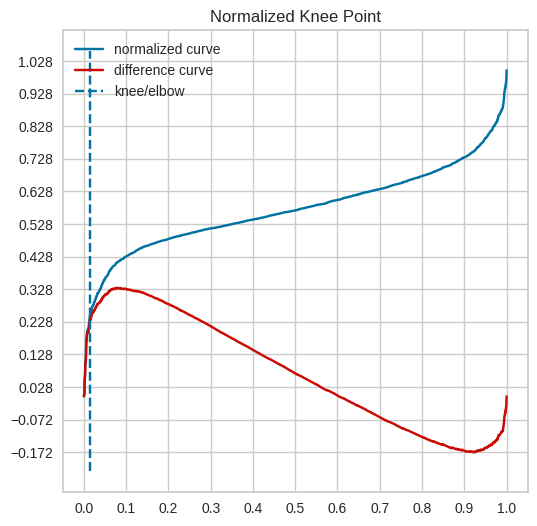

In [ ]:
# draw the knee point to see if a good epsilon exists
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()

In [ ]:
# possibly best epsilon
kneedle.knee_y

0.5994732259528669

### DBSCAN on X

To further explore the hyper parameters, a grid search on different combinations of **epsilon** and **min_points** are tested.

100%|██████████| 432/432 [00:47<00:00,  9.11it/s]


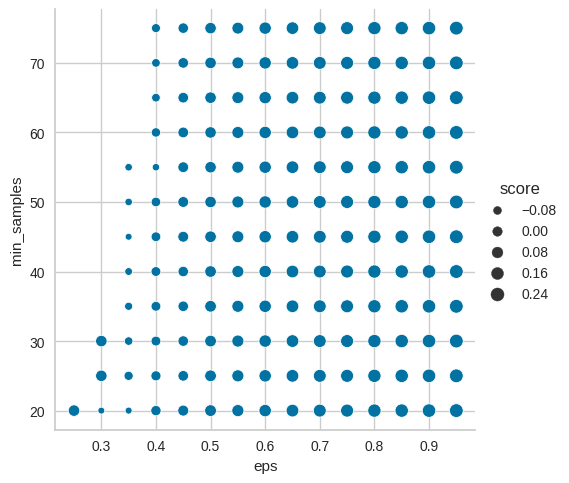

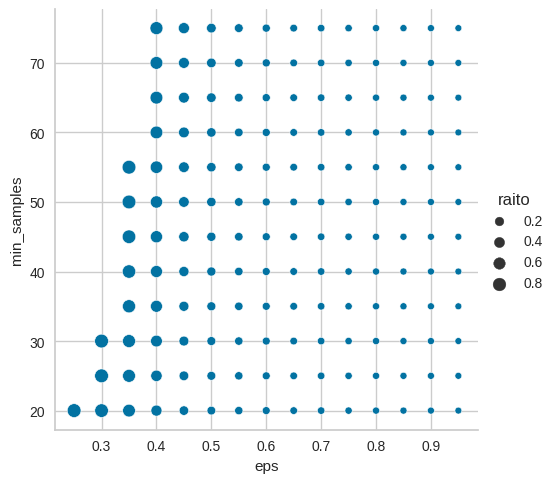

In [ ]:
# combine eps and min_samples, then test each combination and store the result in rs
rs= []
eps = np.arange(0.2,2,0.05) 
min_samples=np.arange(20,80,5)
 
best_score=0
best_score_eps=0
best_score_min_samples=0

for i,j in tqdm(list(itertools.product(eps, min_samples))):
    try:
      db = DBSCAN(eps=i, min_samples=j).fit(X_reduced)
      labels= db.labels_
      k=metrics.silhouette_score(X_reduced, labels) 
      raito = len(labels[labels[:] == -1]) / len(labels)
      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
      rs.append([i,j,k,raito,n_clusters_])
      if k>best_score:
        best_score=k
        best_score_eps=i
        best_score_min_samples=j
    except:
      db='' 
    else:
      db=''
rs= pd.DataFrame(rs)
rs.columns=['eps','min_samples','score','raito','n_clusters']

# plot the result
sns.relplot(x="eps",y="min_samples", size='score',data=rs)
sns.relplot(x="eps",y="min_samples", size='raito',data=rs)

The larger the score, the better.

The smaller the (noise) ratio, the better.

In [ ]:
# the best combination
best_score_eps, best_score_min_samples

(0.9499999999999997, 20)

In [ ]:
# the best score
best_score

0.29685431692315434

In [ ]:
# use the best parameters to cluster
dbscan = DBSCAN(eps=best_score_eps, min_samples=best_score_min_samples)

In [ ]:
labels = dbscan.fit(X_reduced).labels_

In [ ]:
X_reduced

array([[ 0.39701309, -0.03668867,  0.03354578, ...,  0.01362063,
        -0.03376817, -0.02393004],
       [ 0.29860105, -0.01173701,  0.00633862, ...,  0.00758095,
        -0.03144971, -0.01473109],
       [ 0.45993836, -0.03726998,  0.026993  , ...,  0.0069705 ,
        -0.04703045, -0.01345336],
       ...,
       [ 0.6240179 , -0.11678253,  0.00578128, ...,  0.01530729,
        -0.01167132,  0.02148961],
       [ 0.64136339, -0.11855019,  0.00765732, ...,  0.01871672,
         0.00253357,  0.02073769],
       [ 0.62610317, -0.10664464, -0.00110802, ...,  0.01521529,
         0.0155892 ,  0.02501548]])

In [ ]:
np.unique(labels)

array([-1,  0], dtype=int32)

We found that there's only 1 label. -1 stands for noise. This is not a good clustering result.

In [ ]:
pd.DataFrame(labels, columns=['labels']).groupby(['labels'])['labels'].count()

labels
-1       2
 0    2948
Name: labels, dtype: int64

## K-Means clustering on X_reduced

Since DBSCAN isn't working, K-Means is tested below.

K-Means has only one hyper parameter:

+ K

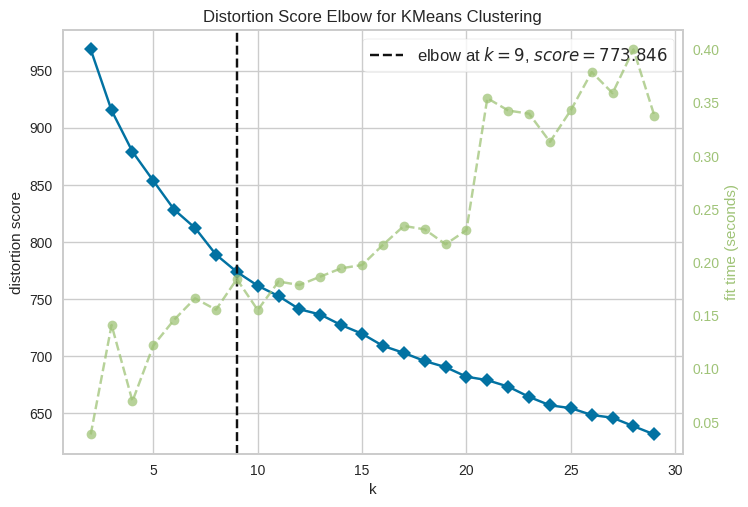

<Figure size 800x550 with 0 Axes>

In [66]:
# use elbow method to find the best K
km = KMeans(random_state=114514, n_init=10)
visualizer = KElbowVisualizer(km, k=(2, 30))
visualizer.fit(X_reduced)
visualizer.show()


In [69]:
visualizer.show(outpath = path + 'kmeanselbow.png')

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

<Figure size 800x550 with 0 Axes>

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/daal4py/sklearn/cluster/_k_means_0_23.py:184: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 1/14 [00:00<00:05,  2.36it/s]/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/daal4py/sklearn/cluster/_k_means_0_23.py:184: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

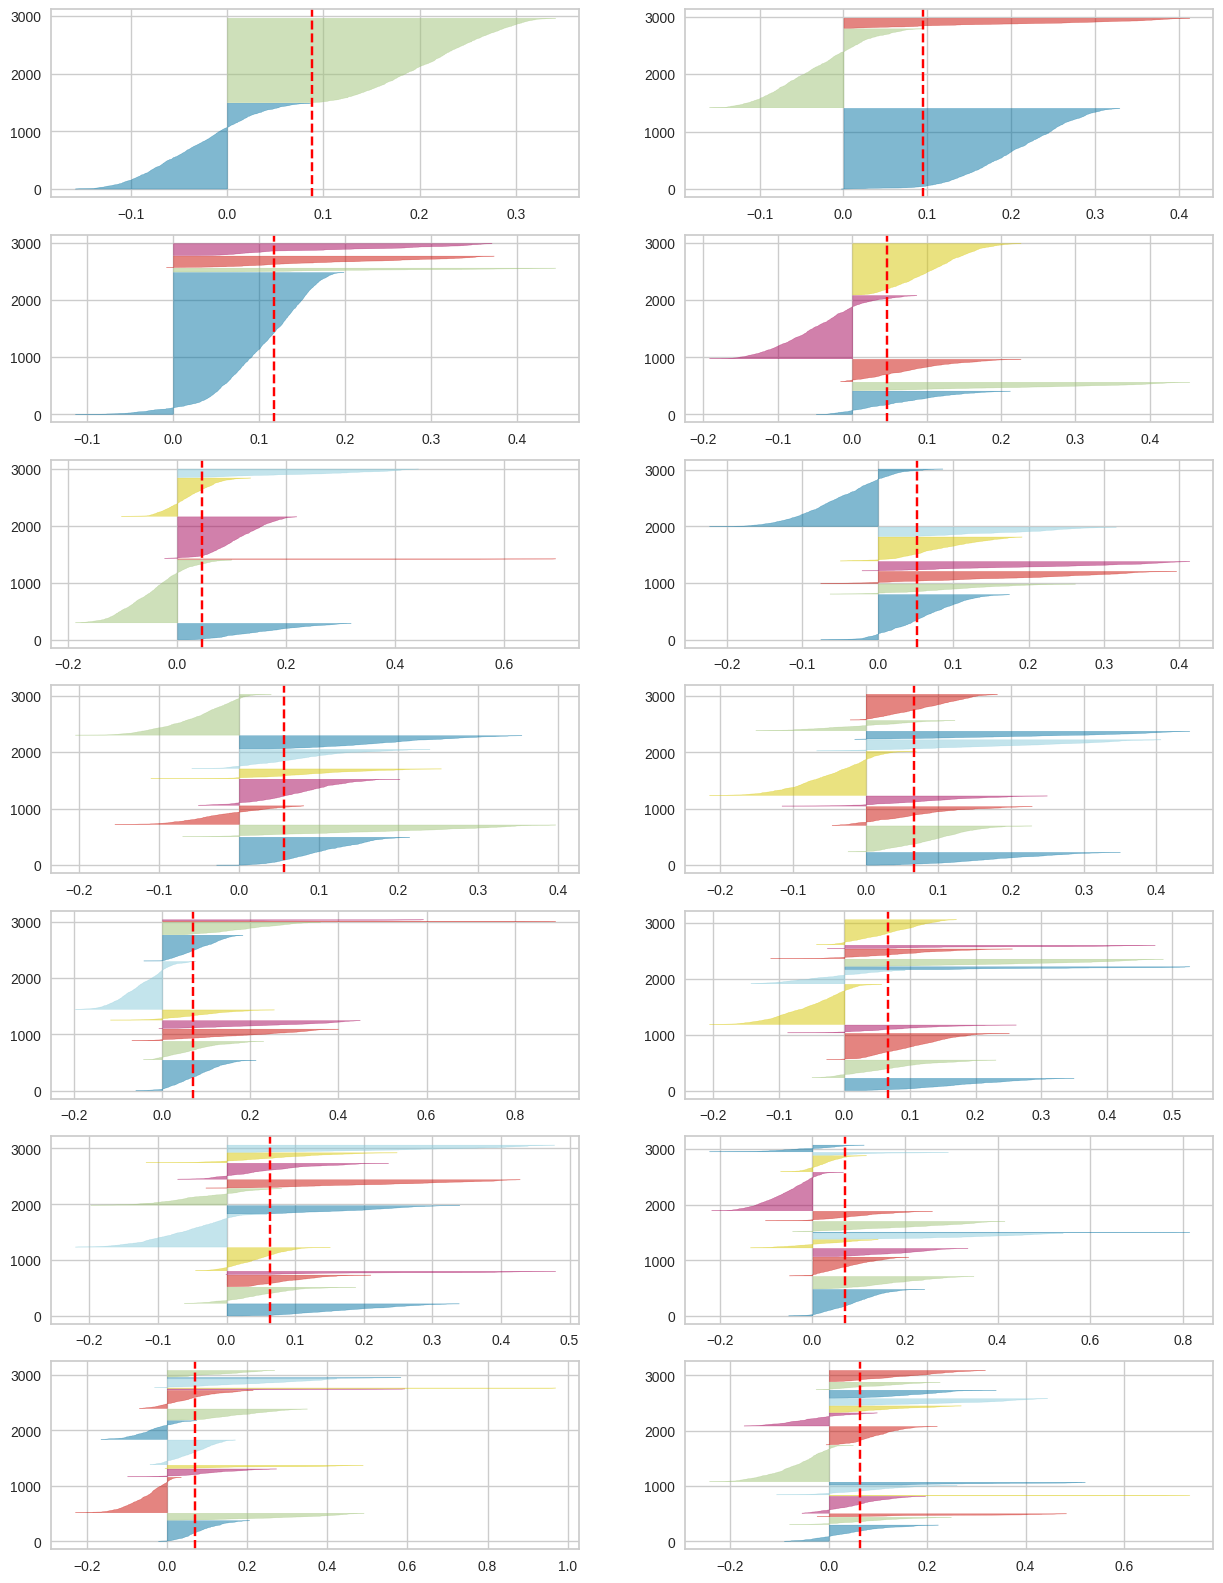

In [58]:
# use silhouette score to explore if it really works
fig, ax = plt.subplots(7, 2, figsize=(15, 20))
sil_score = []
for i in tqdm(range(2, 16)):
    km = KMeans(n_clusters=i, random_state=114514)
    q, mod = divmod(i-2, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(X_reduced) 
    sil_score.append(visualizer.silhouette_score_)

In [60]:
sil_score

[0.08864850824489194,
 0.09456774092530854,
 0.11744056673500333,
 0.04697094030614989,
 0.045538935564599176,
 0.051694480820699794,
 0.05688275720233781,
 0.06615708402044329,
 0.07069166655475698,
 0.06617911484941388,
 0.06370733391205798,
 0.07128133728683815,
 0.07030568247488755,
 0.06401031971732953]

The score is in fact bad. There're several groups that are not actually clustering.

## K-Means on X

In [ ]:
km = KMeans(random_state=114514, n_init=10)
visualizer = KElbowVisualizer(km, k=(2, 30))
visualizer.fit(X.toarray())
visualizer.show()

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


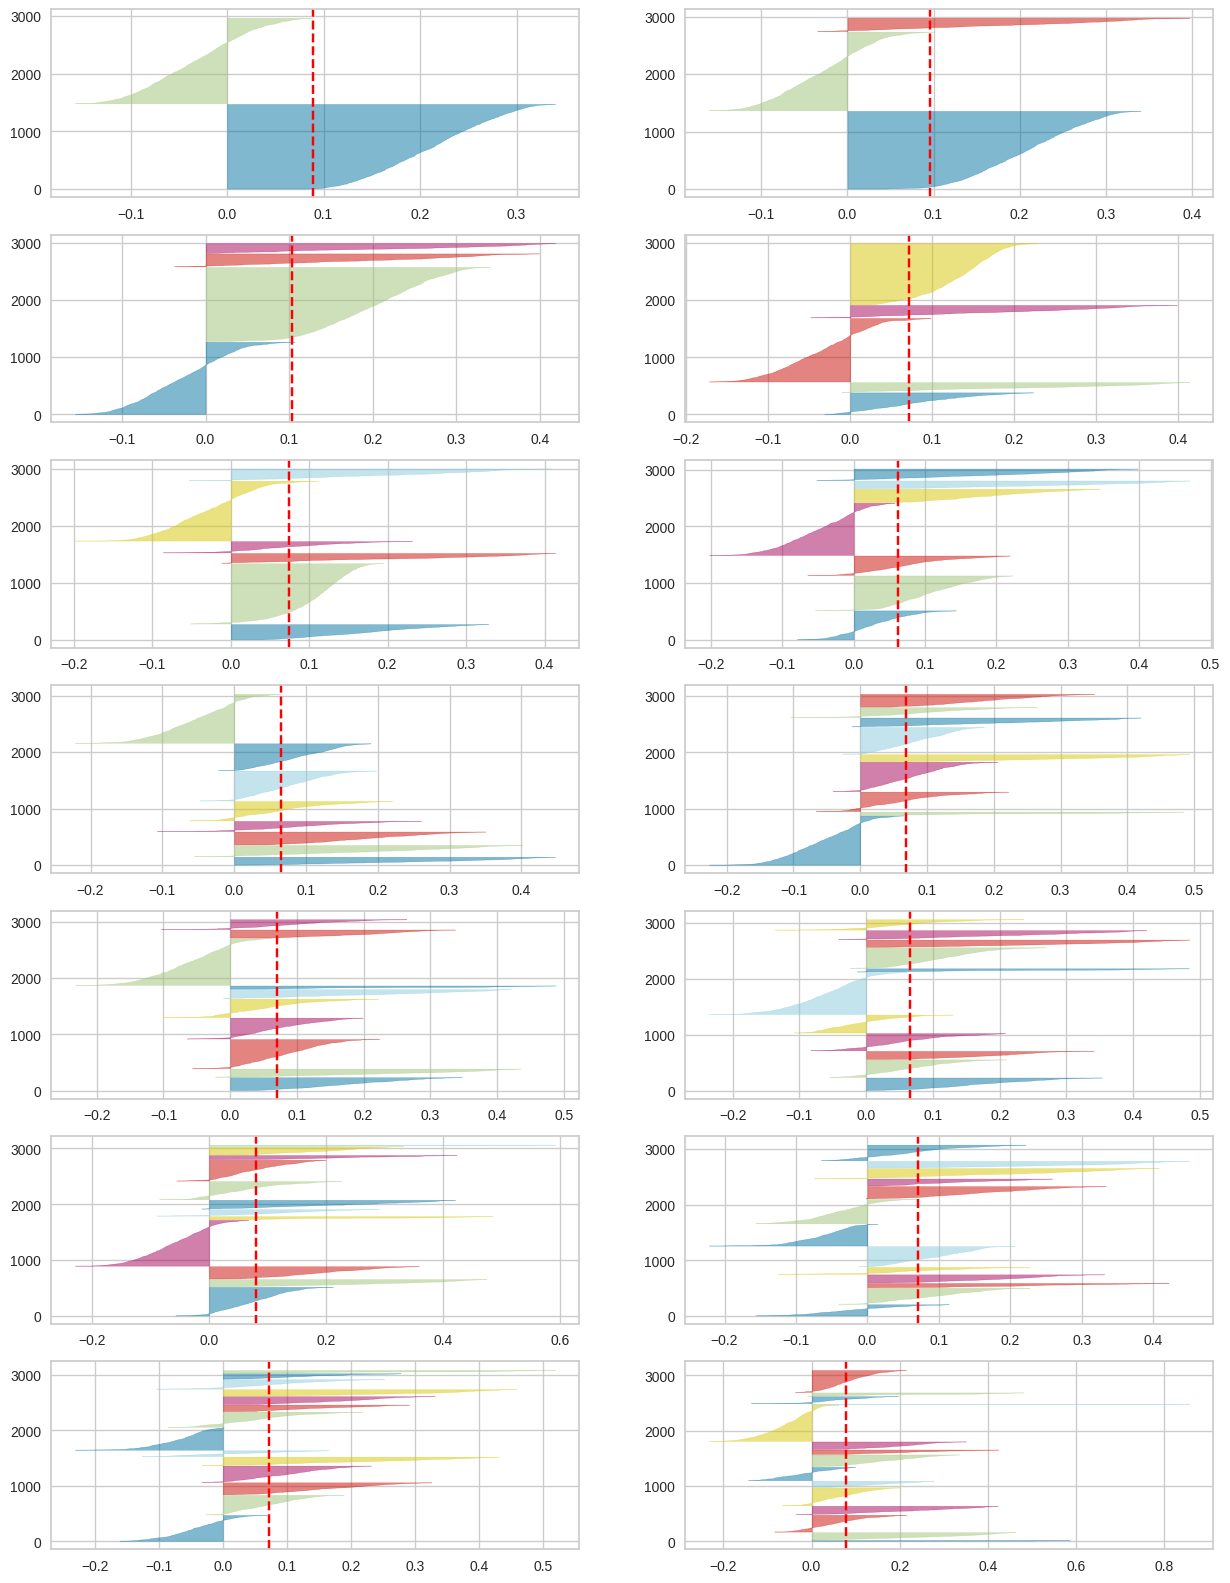

In [ ]:
fig, ax = plt.subplots(7, 2, figsize=(15, 20))
sil_score = []
for i in tqdm(range(2, 16)):
    km = KMeans(n_clusters=i, random_state=114514)
    q, mod = divmod(i-2, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(X_reduced) 
    sil_score.append(visualizer.silhouette_score_)

In [ ]:
sil_score

[0.08893880701846346,
 0.09603403198658463,
 0.1040436107903922,
 0.07192346985531645,
 0.07491063276581429,
 0.06265794846924219,
 0.0656358988890406,
 0.06866626498233824,
 0.07080889783496166,
 0.06538586150356737,
 0.07975059094898768,
 0.07035799226066337,
 0.07222558035436598,
 0.07878046619923065]

## AgglomerativeClustering

Agglomerative clustering is a tree-based hierarchical clustering method.

In [ ]:
# linkage ‘ward’, ‘complete’, ‘average’, ‘single’
agglos = []
sils= []
chs=[]
for i in tqdm(range(2,15)):
  agglo = AgglomerativeClustering(linkage = 'ward', n_clusters=i)
  agglo.fit(X_reduced)
  sils.append(silhouette_score(X_reduced,
                              agglo.labels_,
                              metric='euclidean'))
  chs.append(calinski_harabasz_score(X_reduced,
                              agglo.labels_))
  agglos.append(agglo)

100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Text(0.5, 0, 'K')

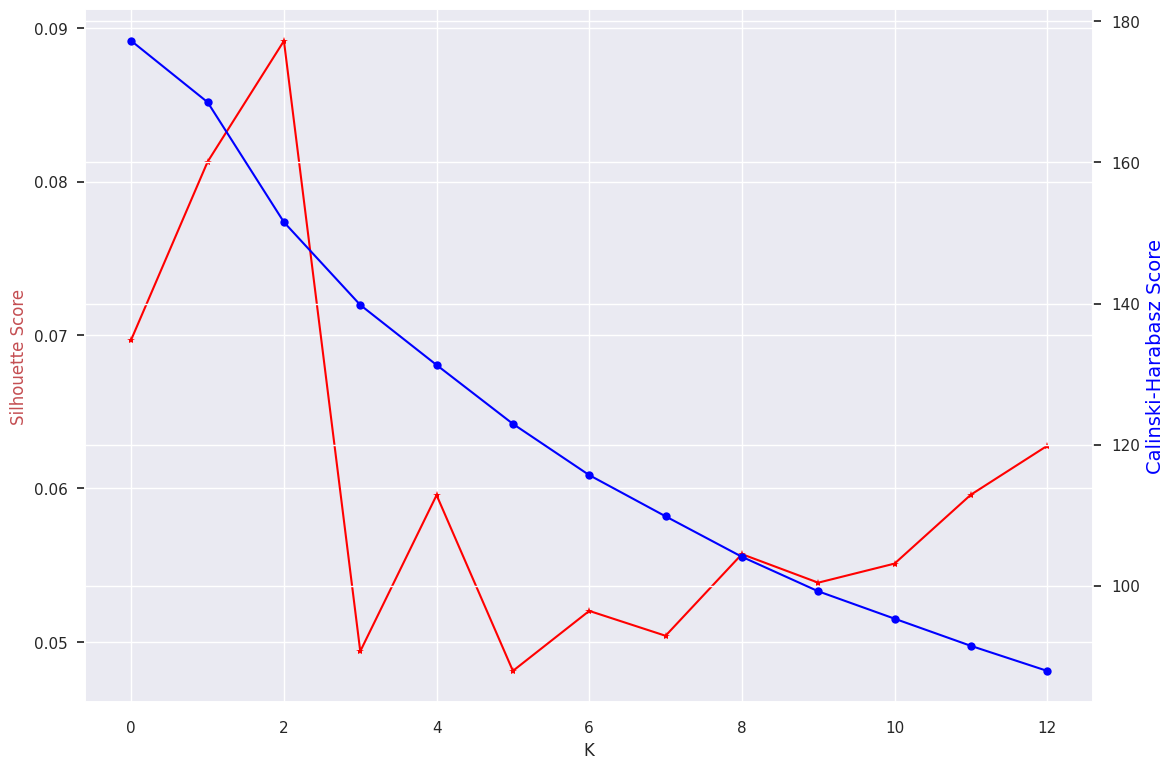

In [ ]:
# both the higher, the better
fig,ax = plt.subplots()
ax.plot(sils, color='red',marker='*')
ax2=ax.twinx()
ax.set_ylabel("Silhouette Score",color='r')
ax2.plot(chs, color="blue",marker="o")
ax2.set_ylabel("Calinski-Harabasz Score", color='blue',fontsize=14)
ax.set_xlabel('K')



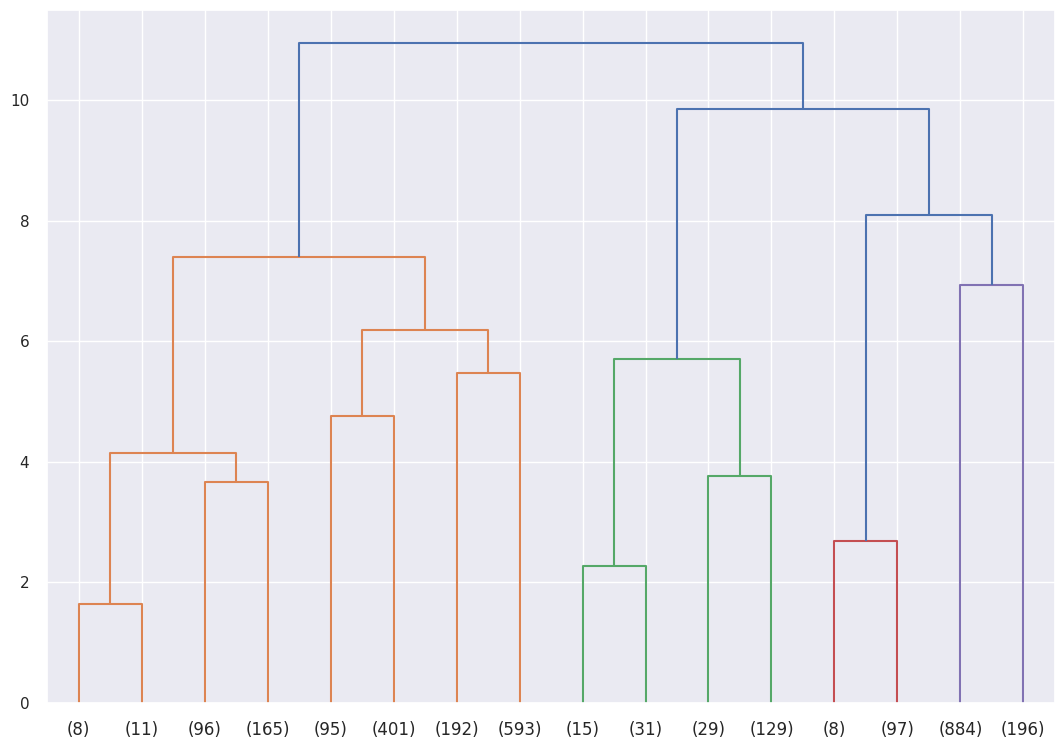

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(X_reduced)
plot_dendrogram(model, truncate_mode="level", p=3)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Final model - K-Means of 9 clusters

In [ ]:
# use n_clusters of 9
kmeans = KMeans(n_clusters=9, random_state=114514)
firm_year['cluster'] = kmeans.fit_predict(X_reduced)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/daal4py/sklearn/cluster/_k_means_0_23.py:184: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# show the count of (firm, year) pairs in each cluster
firm_year.groupby(['cluster']).gvkey.count()

cluster
0    226
1    460
2    332
3    180
4    779
5    197
6    141
7    181
8    454
Name: gvkey, dtype: int64

In [ ]:
# save to drive
firm_year.to_csv(path + 'cluster_label' + str(int(time.time())) + '.csv')

# Visualization

## t-SNE to draw

In [ ]:
# t-SNE not supported well. reimport sklearn
sklearnex.unpatch_sklearn()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(verbose=1, perplexity=50)


In [ ]:
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2950 samples in 0.010s...
[t-SNE] Computed neighbors for 2950 samples in 1.745s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2950
[t-SNE] Computed conditional probabilities for sample 2000 / 2950
[t-SNE] Computed conditional probabilities for sample 2950 / 2950
[t-SNE] Mean sigma: 0.391494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.753571
[t-SNE] KL divergence after 1000 iterations: 1.173792


<ipython-input-133-545f63fc7394>:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=firm_year.cluster, legend='full', palette=palette)


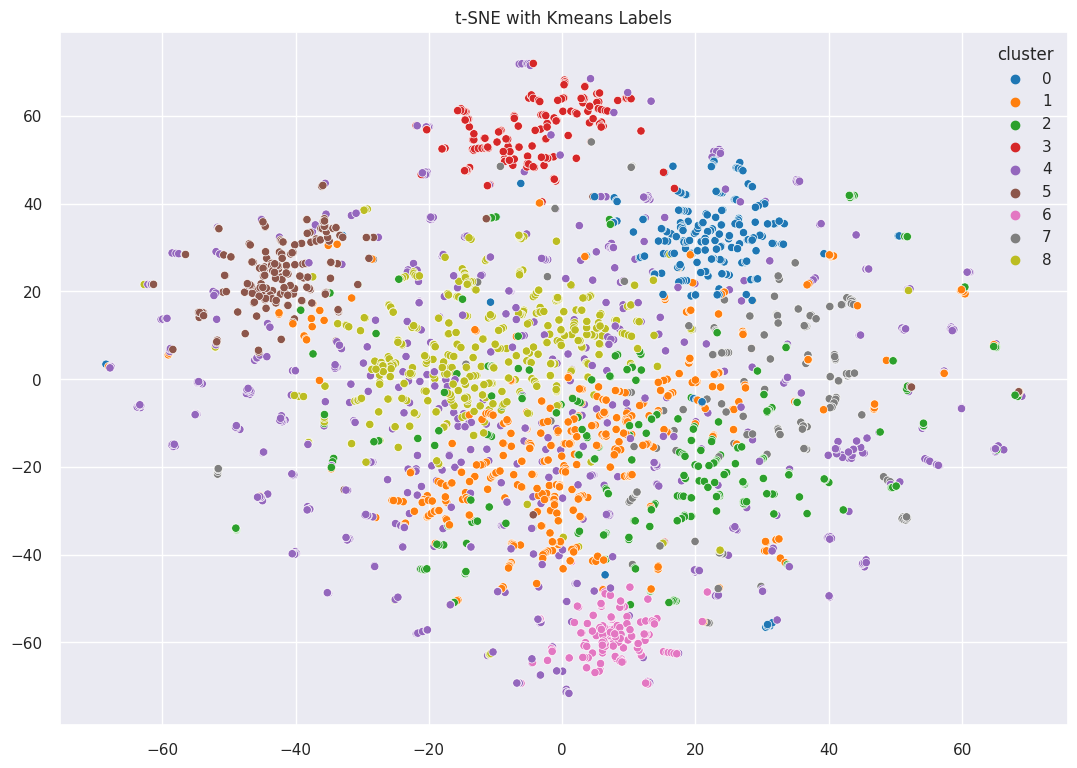

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})

palette = sns.color_palette("tab10")

sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=firm_year.cluster, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig(path + 'tsne.png', transparent=True)
plt.show()

## LDA

In [ ]:
# a self-supervised learning method to visualize data
lda_rd = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda_rd.fit_transform(X.toarray(), firm_year.cluster)


<ipython-input-289-b2a5434bc9aa>:5: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.



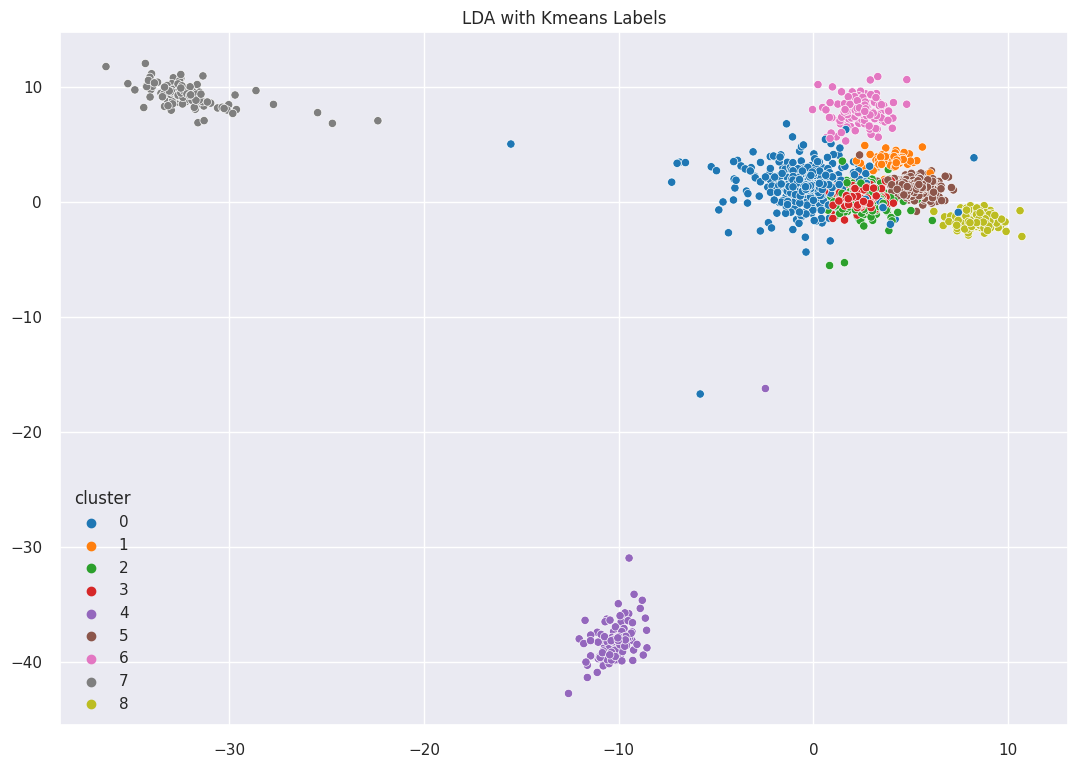

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})

palette = sns.color_palette("tab10")

sns.scatterplot(x = X_lda[:,0], y = X_lda[:,1], hue=firm_year.cluster, legend='full', palette=palette)
plt.title('LDA with Kmeans Labels')
plt.show()

<ipython-input-290-45b36f674f62>:8: UserWarning:

The palette list has more values (10) than needed (9), which may not be intended.



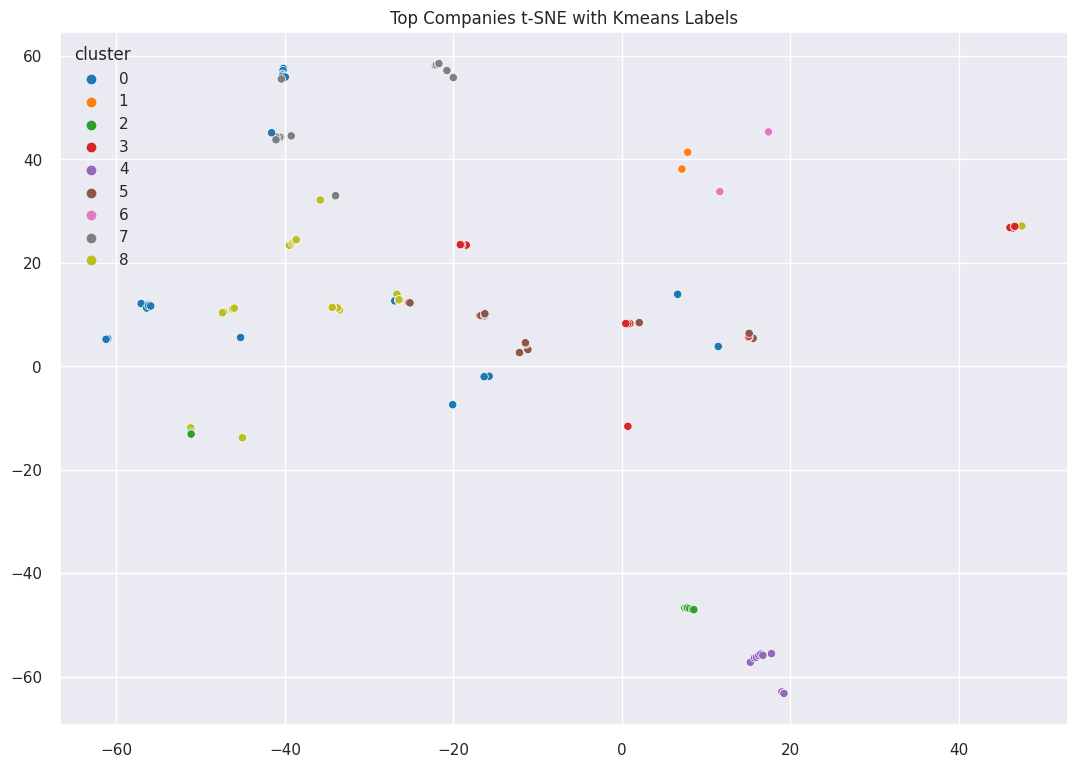

In [ ]:
# Top 20 company label
top_index = firm_year['gvkey'].isin(jd_count.head(20).gvkey)

sns.set(rc={'figure.figsize':(13,9)})

palette = sns.color_palette("tab10")

sns.scatterplot(x = X_embedded[top_index,0], y = X_embedded[top_index,1], hue=firm_year[top_index].cluster, legend='full', palette=palette)
plt.title('Top Companies t-SNE with Kmeans Labels')
plt.show()

# Topic modeling on clusters

To find the topic of each cluster, topic modeling is used on the word bags of concatenated text

In [ ]:
vectorizers = []
    
for ii in range(9):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(firm_year.loc[firm_year['cluster'] == current_cluster, 'clean_description']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
len(vectorized_data)

9

In [ ]:
lda_models = []

for ii in range(9):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online',verbose=False, random_state=114514)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', random_state=114514,
                          verbose=False)

In [ ]:
clusters_lda_data = []

for i in tqdm(range(len(lda_models))):
    if vectorized_data[i] != None:
        clusters_lda_data.append(lda_models[i].fit_transform(vectorized_data[i]))

100%|██████████| 9/9 [03:31<00:00, 23.45s/it]


In [ ]:
def selected_topics(model, vectorizer, top_n=3):
  current_words = []
  keywords = []
    
  for idx, topic in enumerate(model.components_):
    features = list(vectorizer.vocabulary_.keys())
    words = [(features[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
    for word in words:
      if word[0] not in current_words:
        keywords.append(word)
        current_words.append(word[0])

  keywords.sort(key = lambda x: x[1])  
  keywords.reverse()
  return_values = []
  for ii in keywords:
      return_values.append(ii[0])
  return return_values

In [ ]:
all_keywords = []
for i in tqdm(range(len(lda_models))):
    if vectorized_data[i] != None:
        all_keywords.append(selected_topics(lda_models[i], vectorizers[i]))

100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


In [ ]:
all_keywords

[['inspect',
  'healthcare',
  'url',
  'recolor',
  'items',
  'hard',
  'enthusiastically',
  'vpc',
  'purchasing',
  'alignment',
  'prevents',
  'camp',
  'ribbon',
  'tier',
  'economic',
  'immersive',
  'riskopportunity',
  'width',
  'acquisition',
  'staying',
  'televisions'],
 ['rrsp',
  'industrials',
  'themen',
  'workingwith',
  'wheel',
  'thinks',
  'chops',
  'publications',
  'toe',
  'dar',
  'polticas',
  'intermediateadvanced',
  'upselling',
  'matures',
  'sean',
  'morgan',
  'pour',
  'viele',
  'interrogation',
  'fundierte',
  'subsurface',
  'qualityregulatory',
  'fluency'],
 ['pregnancy',
  'websites',
  'ecs',
  'reconciliations',
  'authentic',
  'afi',
  'anwendungen',
  'apa',
  'rapidement',
  'einkauf',
  'healthy',
  'tothe',
  'badge',
  'olika'],
 ['resort',
  'approves',
  'stroll',
  'ascent',
  'brainstorm',
  'furnaces',
  'seek',
  'salad',
  'sizes',
  'cert',
  'exiting',
  'adversely',
  'van',
  'shop',
  'monthly',
  'successful',
  'm

# Similarity score

Cosine similarity score between TF-IDF vectors.

1. Create a pre-step table as a key set of queries.
2. Calculate the cosine similarities
3. Pivot longer and merge with the pre-step table



In [ ]:
pre_table = firm_year[['gvkey','year']].reset_index(drop=False)

In [ ]:
pre_table

index   gvkey  year
0         0    1004  2014
1         1    1004  2015
2         2    1004  2016
3         3    1004  2017
4         4    1004  2018
...     ...     ...   ...
2945   2945  260774  2019
2946   2946  264708  2013
2947   2947  264708  2014
2948   2948  264708  2015
2949   2949  264708  2016

[2950 rows x 3 columns]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities_sparse = cosine_similarity(X, dense_output=False)

In [ ]:
similarities_sparse

<2950x2950 sparse matrix of type '<class 'numpy.float64'>'
	with 8701916 stored elements in Compressed Sparse Row format>

In [ ]:
sim = pd.DataFrame(similarities_sparse.toarray())


In [ ]:
sim

0         1         2         3         4         5         6     \
0     1.000000  0.921439  0.920327  0.718204  0.344596  0.338919  0.343528   
1     0.921439  1.000000  0.915975  0.762913  0.358140  0.245710  0.238470   
2     0.920327  0.915975  1.000000  0.726280  0.352626  0.355772  0.350805   
3     0.718204  0.762913  0.726280  1.000000  0.849692  0.167077  0.165862   
4     0.344596  0.358140  0.352626  0.849692  1.000000  0.123324  0.121146   
...        ...       ...       ...       ...       ...       ...       ...   
2945  0.107180  0.082927  0.125749  0.057437  0.044284  0.211973  0.190233   
2946  0.205990  0.138579  0.217128  0.091237  0.066220  0.351937  0.335393   
2947  0.250378  0.180375  0.282040  0.122714  0.090566  0.426038  0.420713   
2948  0.257138  0.183173  0.290620  0.129071  0.096255  0.435825  0.432036   
2949  0.250619  0.180251  0.275962  0.126137  0.096093  0.428687  0.425954   

          7         8         9     ...      2940      2941      2942  \
0     0.345342  0.342843  0.358537  ...  0.231095  0.230967  0.321911   
1     0.247827  0.245077  0.251730  ...  0.172887  0.171865  0.229286   
2     0.363203  0.369530  0.368496  ...  0.262972  0.266920  0.357208   
3     0.169140  0.191816  0.208378  ...  0.122202  0.122563  0.164738   
4     0.124644  0.156552  0.169239  ...  0.095063  0.095020  0.132446   
...        ...       ...       ...  ...       ...       ...       ...   
2945  0.186895  0.184875  0.165255  ...  0.255187  0.215961  0.255234   
2946  0.355364  0.328459  0.300217  ...  0.284708  0.253419  0.354444   
2947  0.452006  0.430358  0.395242  ...  0.371529  0.345657  0.481419   
2948  0.467602  0.437048  0.401336  ...  0.376510  0.359652  0.463438   
2949  0.455165  0.421584  0.393026  ...  0.363763  0.358145  0.446402   

          2943      2944      2945      2946      2947      2948      2949  
0     0.280626  0.165460  0.107180  0.205990  0.250378  0.257138  0.250619  
1     0.196661  0.120802  0.082927  0.138579  0.180375  0.183173  0.180251  
2     0.315572  0.191135  0.125749  0.217128  0.282040  0.290620  0.275962  
3     0.230923  0.264797  0.057437  0.091237  0.122714  0.129071  0.126137  
4     0.248067  0.333188  0.044284  0.066220  0.090566  0.096255  0.096093  
...        ...       ...       ...       ...       ...       ...       ...  
2945  0.249821  0.165170  1.000000  0.137621  0.150566  0.160883  0.152307  
2946  0.326973  0.198854  0.137621  1.000000  0.760466  0.731767  0.657866  
2947  0.417997  0.250679  0.150566  0.760466  1.000000  0.907531  0.820856  
2948  0.424691  0.255556  0.160883  0.731767  0.907531  1.000000  0.897275  
2949  0.403808  0.244124  0.152307  0.657866  0.820856  0.897275  1.000000  

[2950 rows x 2950 columns]

In [ ]:
sim_pair = sim.melt(ignore_index=False).reset_index()

In [ ]:
sim_pair

index  variable     value
0            0         0  1.000000
1            1         0  0.921439
2            2         0  0.920327
3            3         0  0.718204
4            4         0  0.344596
...        ...       ...       ...
8702495   2945      2949  0.152307
8702496   2946      2949  0.657866
8702497   2947      2949  0.820856
8702498   2948      2949  0.897275
8702499   2949      2949  1.000000

[8702500 rows x 3 columns]

In [ ]:
pd.merge(sim_pair, pre_table, how='left', left_on='index', right_on ='index', suffixes=('', '_l'))

index  variable     value   gvkey  year
0            0         0  1.000000    1004  2014
1            1         0  0.921439    1004  2015
2            2         0  0.920327    1004  2016
3            3         0  0.718204    1004  2017
4            4         0  0.344596    1004  2018
...        ...       ...       ...     ...   ...
8702495   2945      2949  0.152307  260774  2019
8702496   2946      2949  0.657866  264708  2013
8702497   2947      2949  0.820856  264708  2014
8702498   2948      2949  0.897275  264708  2015
8702499   2949      2949  1.000000  264708  2016

[8702500 rows x 5 columns]

In [ ]:
merge_sim = pd.merge(pd.merge(sim_pair, pre_table, how='left', left_on='index', right_on ='index', suffixes=('', '_l')), pre_table, how='left', left_on='variable',right_on='index',suffixes=('', '_r'))

In [ ]:
result = merge_sim[(merge_sim['gvkey']==merge_sim['gvkey_r'])|(merge_sim['year']==merge_sim['year_r'])]

In [ ]:
result = result[['gvkey', 'year', 'gvkey_r', 'year_r', 'value']]

In [ ]:
result

gvkey  year  gvkey_r  year_r     value
0          1004  2014     1004    2014  1.000000
1          1004  2015     1004    2014  0.921439
2          1004  2016     1004    2014  0.920327
3          1004  2017     1004    2014  0.718204
4          1004  2018     1004    2014  0.344596
...         ...   ...      ...     ...       ...
8702492  260774  2016   264708    2016  0.446402
8702496  264708  2013   264708    2016  0.657866
8702497  264708  2014   264708    2016  0.820856
8702498  264708  2015   264708    2016  0.897275
8702499  264708  2016   264708    2016  1.000000

[1273482 rows x 5 columns]

In [10]:
# comment if run from beginning
# result = pd.read_csv(path + "jd_similarities1680123278.csv")
result

Unnamed: 0   gvkey  year  gvkey_r  year_r     value
0                 0    1004  2014     1004    2014  1.000000
1                 1    1004  2015     1004    2014  0.921439
2                 2    1004  2016     1004    2014  0.920327
3                 3    1004  2017     1004    2014  0.718204
4                 4    1004  2018     1004    2014  0.344596
...             ...     ...   ...      ...     ...       ...
1273477     8702492  260774  2016   264708    2016  0.446402
1273478     8702496  264708  2013   264708    2016  0.657866
1273479     8702497  264708  2014   264708    2016  0.820856
1273480     8702498  264708  2015   264708    2016  0.897275
1273481     8702499  264708  2016   264708    2016  1.000000

[1273482 rows x 6 columns]

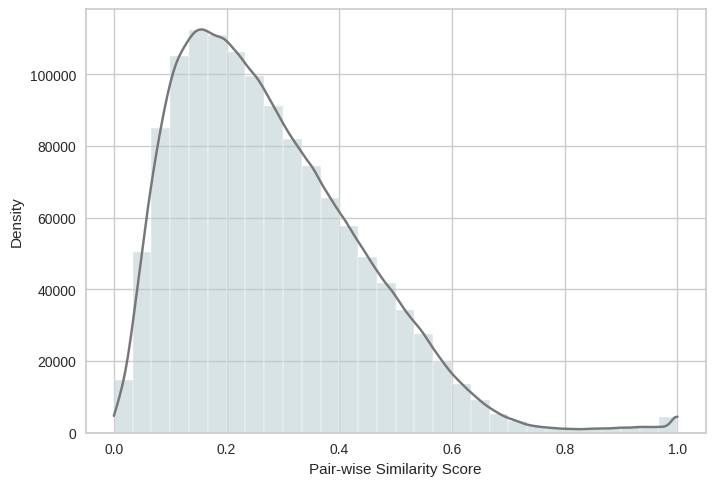

In [39]:
ax = sns.histplot(data=result,
             x="value",
             bins=30,
             kde=True,
             color = "#B3C9CD",
             edgecolor = "white")
ax.lines[0].set_color('#777777')
plt.xlabel('Pair-wise Similarity Score')
plt.ylabel('Density')
plt.savefig(path + 'similarity.png', transparent=True)
plt.show()

In [ ]:
path

'/content/drive/MyDrive/capstone_data/'

In [ ]:
file_name = 'jd_similarities' + str(int(time.time())) + '.csv'
print(file_name)

jd_similarities1680123278.csv


In [ ]:
result.to_csv(path + file_name)

# Example analytics on top companies

## Cluster and industry


In [ ]:
industry_code = pd.read_csv(path+ 'gvkey_industries.csv')

In [ ]:
# https://www.census.gov/naics/?58967?yearbck=2022
industry_nai = {k[0]:k[1] for k in [
[11,	'Agriculture, Forestry, Fishing and Hunting'],
[21,	'Mining, Quarrying, and Oil and Gas Extraction'],
[22, 'Utilities'],
[23, 'Construction'],
[31,	'Manufacturing'],
[32, 'Manufacturing'],
[33, 'Manufacturing'],
[42,	'Wholesale Trade'],
[44, 'Retail Trade'],
[45,	'Retail Trade'],
[48, 'Transportation and Warehousing'],
[49,	'Transportation and Warehousing'],
[51,	'Information'],
[52,	'Finance and Insurance'],
[53,	'Real Estate and Rental and Leasing'],
[54,	'Professional, Scientific, and Technical Services'],
[55,	'Management of Companies and Enterprises'],
[56,	'Administrative and Support and Waste Management and Remediation Services'],
[61,	'Educational Services'],
[62,	'Health Care and Social Assistance'],
[71,	'Arts, Entertainment, and Recreation'],
[72,	'Accommodation and Food Services'],
[81,	'Other Services (except Public Administration)'],
[92,	'Public Administration']]}

In [ ]:
industry_code['industry'] = (industry_code['naicsh']//10000).map(industry_nai)

In [ ]:
industry_firm_year = pd.merge(firm_year, industry_code, how='left', left_on=['gvkey', 'year'], right_on = ['gvkey', 'fyear'])

In [ ]:
cluster_top3key = list(map(lambda x: ' '.join(x[:3]) ,all_keywords))
cluster_map = {i: cluster_top3key[i] for i in range(9)}

In [ ]:
cluster_top3key

['inspect healthcare url',
 'rrsp industrials themen',
 'pregnancy websites ecs',
 'resort approves stroll',
 'tco baked paired',
 'uniqueness bhr vorsorgeuntersuchungen',
 'flowing budgeted mopping',
 'advise test trail',
 'realworld vod donde']

In [ ]:
clu_ind_result = industry_firm_year.groupby(['cluster','industry'])['gvkey'].count().reset_index()
clu_ind_result['cluster_key'] = clu_ind_result['cluster'].map(cluster_map)

In [ ]:
clu_ind_result

cluster                                          industry  gvkey  \
0          0                   Accommodation and Food Services      2   
1          0                             Finance and Insurance      4   
2          0                                     Manufacturing     10   
3          0                Real Estate and Rental and Leasing      7   
4          0                                      Retail Trade    182   
..       ...                                               ...    ...   
97         8     Mining, Quarrying, and Oil and Gas Extraction      1   
98         8  Professional, Scientific, and Technical Services     57   
99         8                Real Estate and Rental and Leasing      5   
100        8                                      Retail Trade      6   
101        8                                   Wholesale Trade      2   

                cluster_key  
0    inspect healthcare url  
1    inspect healthcare url  
2    inspect healthcare url  
3    inspect healthcare url  
4    inspect healthcare url  
..                      ...  
97      realworld vod donde  
98      realworld vod donde  
99      realworld vod donde  
100     realworld vod donde  
101     realworld vod donde  

[102 rows x 4 columns]

In [ ]:
import textwrap

100%|██████████| 9/9 [00:00<00:00, 22.13it/s]


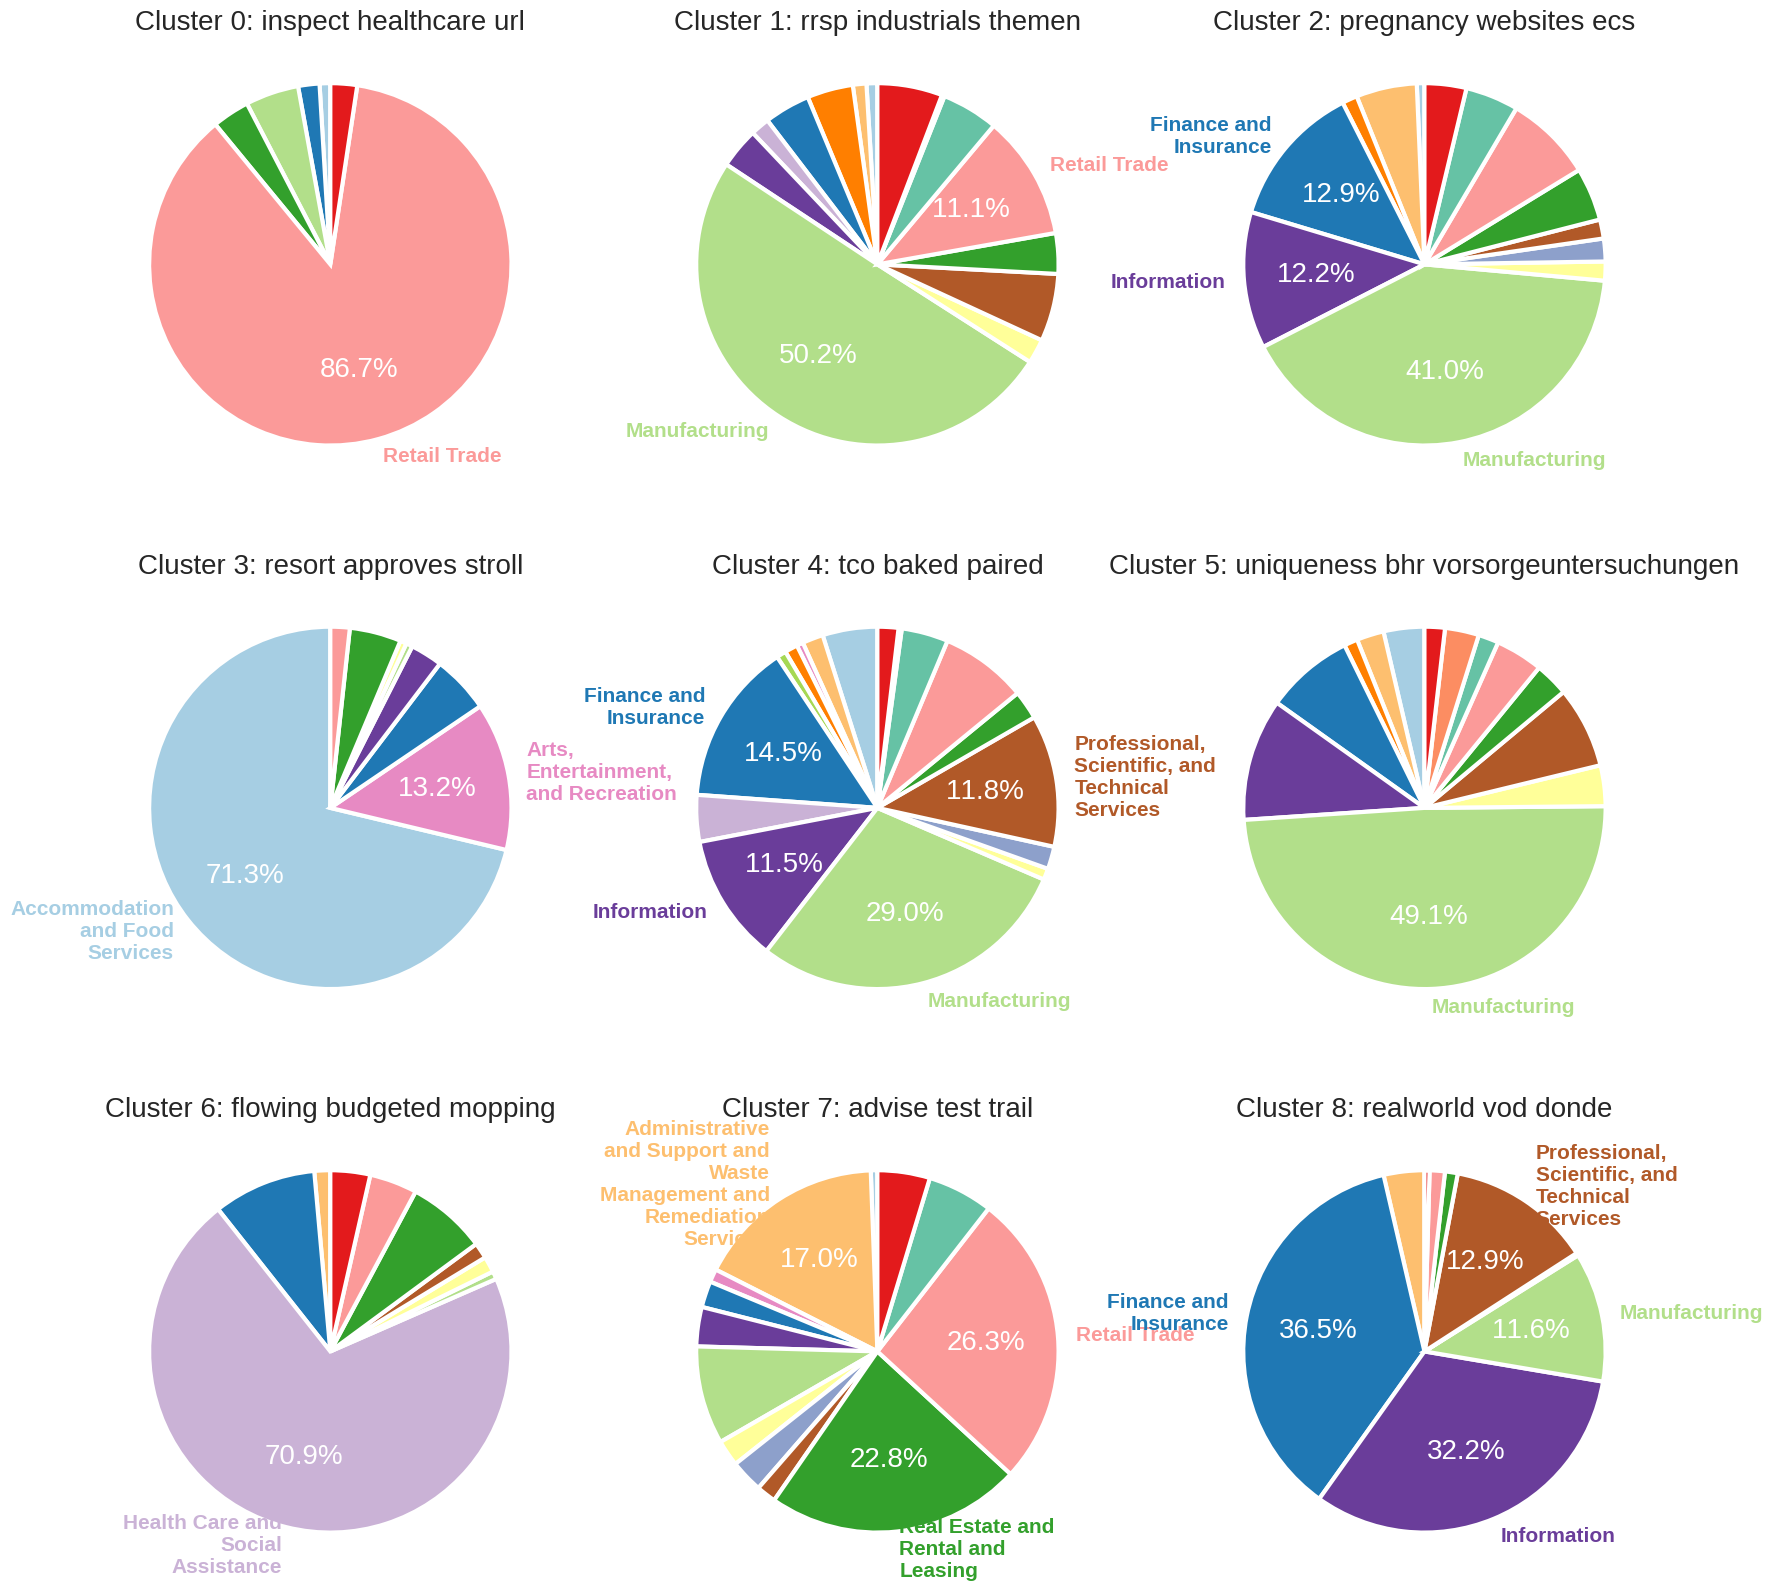

In [ ]:
visible_pct = 11

def make_labels(df):
  ls = []
  for i in range(len(df)):
    if (df.gvkey[i]*100/df.gvkey.sum()) >= visible_pct :
      ls.append(df.industry[i])
  return ls


colors = sns.color_palette("Paired") + sns.color_palette("Set2")
color_map = dict(zip(clu_ind_result.industry.unique(), colors))
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
sil_score = []
for i in tqdm(range(9)):
  labels = clu_ind_result[clu_ind_result['cluster']==i].industry
  label_show = make_labels(clu_ind_result[clu_ind_result['cluster']==i].reset_index())
  patches, texts, pcts = ax[i//3, i%3].pie(clu_ind_result[clu_ind_result['cluster']==i].gvkey,
                                            labels = labels,
                                            autopct= lambda x: '%.1f%%'%x if x>=visible_pct else '',
                                            colors = [color_map[label] for label in labels],
  wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
  startangle=90)
  # For each wedge, set the corresponding text label color to the wedge's
  # face color.
  for j, patch in enumerate(patches):
    if texts[j].get_text() not in label_show:
      texts[j].set(visible=False)
    else:
      texts[j].set_color(patch.get_facecolor())  
      texts[j].set_text(textwrap.fill(texts[j].get_text(), width=15, break_long_words=False))
      texts[j].set_size(15)
  plt.setp(pcts, color='white')
  plt.setp(texts, fontweight=600)
  ax[i//3, i%3].set_title('Cluster ' + str(i) + ": " + cluster_map[i], fontsize=20)
plt.savefig(path + 'clusters.png', transparent=True)
plt.show()

In [ ]:
color_map

{'Accommodation and Food Services': (0.6509803921568628,
  0.807843137254902,
  0.8901960784313725),
 'Finance and Insurance': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765),
 'Manufacturing': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'Real Estate and Rental and Leasing': (0.2,
  0.6274509803921569,
  0.17254901960784313),
 'Retail Trade': (0.984313725490196, 0.6039215686274509, 0.6),
 'Wholesale Trade': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 'Administrative and Support and Waste Management and Remediation Services': (0.9921568627450981,
  0.7490196078431373,
  0.43529411764705883),
 'Construction': (1.0, 0.4980392156862745, 0.0),
 'Health Care and Social Assistance': (0.792156862745098,
  0.6980392156862745,
  0.8392156862745098),
 'Information': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 'Mining, Quarrying, and Oil and Gas Extraction': (1.0, 1.0, 0.6),
 'Professional, Scientific, and Technica

In [ ]:
firm_year

gvkey  year                                  clean_description  cluster
0       1004  2014  position summary leads small teams problem sol...        4
1       1004  2015  working worlds leading aircraft manufacturer m...        4
2       1004  2016  position summary identify engage interdepartme...        2
3       1004  2017  airbus global leader aeronautics space related...        5
4       1004  2018  sie sind vollzeitstudent auf der suche nach ei...        5
...      ...   ...                                                ...      ...
2945  260774  2019  key roles responsibilities generate execute ac...        4
2946  264708  2013  position overview primary purpose operations p...        0
2947  264708  2014  position overview primary purpose operations p...        0
2948  264708  2015  position overview primary purpose operations p...        0
2949  264708  2016  cabelas worlds foremost outfitter hunting fish...        0

[2950 rows x 4 columns]

In [ ]:
firm_year[firm_year['gvkey'].isin([64768, 12141])]

gvkey  year                                  clean_description  cluster
1249  12141  2012  campaign linkedin linkedin marketing solutions...        8
1250  12141  2013  description linkedin looking sr operations per...        8
1251  12141  2014  category operations location bellevue wa divis...        8
1252  12141  2015  windows threshold step forward windows big ste...        2
1253  12141  2016  program global sustainability sunnyvale linked...        2
1254  12141  2017  licensing executive equipedpartement et objet ...        4
1255  12141  2018  role location specific key successful based ne...        5
2210  64768  2012  looking challenge fastpaced innovative come hi...        4
2211  64768  2013  operations complete responsibility inbound ope...        8
2212  64768  2014  operations complete responsibility inbound ope...        1
2213  64768  2015  impact attendees open position submit applicat...        1
2214  64768  2016  private label descriptions sent recruiting bas...        1
2215  64768  2017  update description update description update d...        5
2216  64768  2018  looking affairs executive add studios scripted...        1

## Similarity

In [ ]:
jd_count.head(10)

gvkey  number_of_posts_all
1994  65417              1242568
350    6829               591424
164    3813               519302
371    7241               447444
317    6307               374320
67     2184               365098
1139  22260               360541
1959  64768               360146
1532  29150               311387
214    4611               292160

In [ ]:
result[(result['gvkey']==64768 )& (result['gvkey_r']==12141)]

gvkey  year  gvkey_r  year_r     value
3686760  64768  2012    12141    2012  0.224809
3689711  64768  2013    12141    2013  0.708214
3692662  64768  2014    12141    2014  0.709246
3695613  64768  2015    12141    2015  0.648702
3698564  64768  2016    12141    2016  0.428238
3701515  64768  2017    12141    2017  0.197494
3704466  64768  2018    12141    2018  0.478924